<a href="https://colab.research.google.com/github/kazimhsayed/Astrostatistics/blob/main/MCMC_without_eta_function_for_generalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import random
import copy
#importing Data from where Avinash uploaded it
jla_mub_0 = "https://raw.githubusercontent.com/avinash-tiwary/MCMC/main/jla_mub_0.csv"
jla_mub_covmatrix = 'https://raw.githubusercontent.com/avinash-tiwary/MCMC/main/jla_mub_covmatrix.csv'

data_1, data_2= pd.read_csv(jla_mub_0), pd.read_csv(jla_mub_covmatrix)
z, Mo, cov= data_1.z, data_1.mu, data_2.data

#Reshaping the symmetric Covariance matrix and solving it's inverse
cov=np.array(cov)
cov=np.reshape(cov,(31,31))
invCov=np.linalg.inv(cov)



no_of_parameters = 2    #I WILL USE THIS TO SCALE THE RADIUS WHICH IS UNIFORM, SEE BELOW

N = 4000                #THIS IS FOR THE NO OF TRIALS WE WILL HAVE FOR THE PROPOSED DISTRIBUTION

no_of_chains=4        #WE CAN SAMPLE FROM MULTIPLE CHAINS TOO AND I HAVE SHOWN A SAMPLE ANIMATION OF THEM CONVERGING TO THE TARGET STATIONARY DISTRIBUTION

'''Do you want the proposal process to be uniform or guassian, 
Enter g=0 for uniform, 
g=1 for guassian'''
g=1


C=299792458
def fu(h, w_m):
    if h < 1 and h > 0 and w_m > 0 and w_m < 1:
        DL = np.zeros(len(z))
        WM0 = w_m
        WL0 = 1 - WM0
        H0 = h * 308.5677 * 10 ** -20    #THIS IS IN S.I. UNITS
        WR0 = 0
        WK0 = 0
        n = 1000                      #THIS DETERMINES THE PRECISION
        for i in range(len(z)):
            x = np.linspace(0, z[i], n + 1)  # subsection of A from 0 to z in n divisions
            y = (WR0 * (1 + x) ** 4 + WM0 * (1 + x) ** 3 + WL0 + WK0 * (1 + x) ** 2) ** (
                        -1 / 2)  # The Integrand for proper distance

            # Simpson's Integration
            h = x[1] - x[0]
            S = y[0]
            for j in range(n):
                if j % 2 == 0: S = S + 2 * y[j]
                if j % 2 == 1: S = S + 4 * y[j]
            S = S + y[n]
            S = h / 3 * S  # Final integral value using Simpson's rule
            DL[i] = S * C * H0 ** -1 * (1 + z[i]) * (3.24078 * 10 ** -23)  # Luminosity Distance as a funtion of z
        Mu = 5 * np.log10(DL) + 25                                          #DISTANCE MODULUS
        DMu = Mo - Mu
        log_p = (-0.5 * np.dot(DMu, (np.dot(invCov, DMu))))               #LOG OF LIKELIHOOD
    else:
        log_p = -1*np.exp(100)        #SO THAT LIKELIHOOF ITSELF IS NEARLY ZERO
    return log_p



if g==0:
  #I AM USING A R,THETA APPROACH FOR A CIRCULARLY SYMMETRIC PROPOSAL DISTRIBUTION, THE GUASSIAN OR UNIFORM NATURE IS DETERMINED IN 'r' ONLY 
  #WHICH IS SCALED BY NUMBER OF PARAMETERS TO ACCOUNT FOR FALL OF DENSITY IN THE PARAMETER SPACE
  r = np.random.uniform(0, 0.001, size=(no_of_chains,N)) ** (1 / (no_of_parameters))
  theta = np.random.uniform(0, 2 * np.pi, size=(no_of_chains,N))          #THIS REMAINS UNCHANGED FOR ANY DISTRIBUTION, FOR MORE DIMENSIONS I WILL INCLUDE OTHER THETAS RANGING FROM 0 TO PI



  x1= r * np.cos(theta)
  x2= r * np.sin(theta)
  

if g==1:
    #I AM USING A R,THETA APPROACH FOR A CIRCULARLY SYMMETRIC PROPOSAL DISTRIBUTION, THE GUASSIAN OR UNIFORM NATURE IS DETERMINED IN 'r' ONLY 
  #WHICH IS SCALED BY NUMBER OF PARAMETERS TO ACCOUNT FOR FALL OF DENSITY IN THE PARAMETER SPACE
  variancee=0.01
  
  x1=np.random.normal(0,variancee, size=(no_of_chains,N))
  x2=np.random.normal(0,variancee, size=(no_of_chains,N))
  
  
#THE INITIAL VALUE OR WHERE THE CHAINS ARE STARTING
x_h = np.random.uniform(0, 1,size=(no_of_chains,1))
y_w = np.random.uniform(0, 1,size=(no_of_chains,1))


likelihood=np.empty([no_of_chains,1])

for i in range(no_of_chains):
  likelihood[i,0]=fu(x_h[i,0],y_w[i,0])

#THIS IS WHERE THE FINAL CHAINS WILL BE APPENDED
x_h_master=[]
y_w_master=[]
likelihood_master=[]

#MCMC FOR ALL CHAINS
for v in range(no_of_chains):
  x_h_v=x_h[v,:]
  y_w_v=y_w[v,:]
  likelihood_v=likelihood[v,:]
  for iteration in range(N):
      a_prev=likelihood_v[-1]
      h = x_h_v[-1]
      w_m = y_w_v[-1]
      h_prev = copy.copy(h)
      w_prev = copy.copy(w_m)
      h = h + x1[v,iteration]
      w_m = w_prev + x2[v,iteration]
      a = fu(h,w_m)
      ac_pr = min(np.exp(a - a_prev), 1)
      if np.random.uniform(0, 1) < ac_pr:
          x_h_v = np.append(x_h_v, h)
          y_w_v = np.append(y_w_v, w_m)
          likelihood_v=np.append(likelihood_v,a)

          
  x_h_master.append(x_h_v.tolist())
  y_w_master.append(y_w_v.tolist())
  likelihood_master.append(likelihood_v.tolist())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


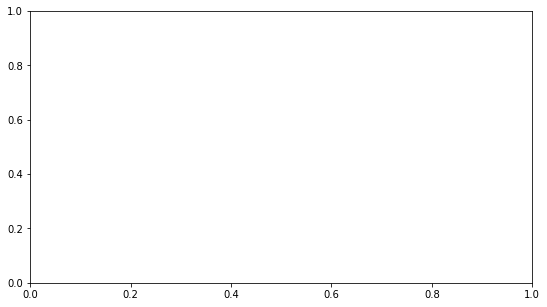

In [ ]:
#THIS IS JUST TO ANIMATE THE PLOT
min_len_chain = N
for i in range(no_of_chains):
    if len(x_h_master[i]) < min_len_chain:
        min_len_chain = len(x_h_master[i])
import matplotlib
import matplotlib.animation as animation

fig = plt.figure(figsize=(9, 5))


def animate(v):
    v = v
    plt.clf()
    for i in range(no_of_chains):

        plt.plot(np.array(y_w_master[i])[:v], np.array(x_h_master[i])[:v],alpha=0.2)
        plt.scatter(np.array(y_w_master[i])[:v], np.array(x_h_master[i])[:v],
                    c=-np.exp(np.array(likelihood_master[i])[:v]))
        plt.xlabel("Omega M")
        plt.ylabel('h')
        plt.xlim(0, 1)
        plt.ylim(0, 1)


ani = animation.FuncAnimation(fig, animate, frames=int(min_len_chain), interval=200)
matplotlib.rcParams['animation.embed_limit'] = 2 ** (246 * 4)
HTML(ani.to_html5_video())

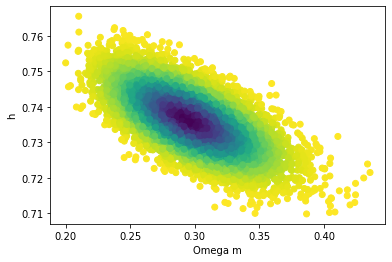

In [ ]:
#DISCARDING BURN IN
h_stationary=np.zeros(0)
w_m_stationary=np.zeros(0)
likelihood_stationary=np.zeros(0)

cutoff=(len(x_h_master[i])/8)
for i in range(no_of_chains):
    h_stationary=np.append(np.array(x_h_master[i])[int(cutoff):],h_stationary)
    w_m_stationary=np.append(np.array(y_w_master[i])[int(cutoff):],w_m_stationary)
    likelihood_stationary=np.append(np.array(likelihood_master[i])[int(cutoff):],likelihood_stationary)

plt.scatter(w_m_stationary,h_stationary,c=-np.exp(likelihood_stationary),alpha=1)
plt.xlabel('Omega m')
plt.ylabel('h')
plt.show()


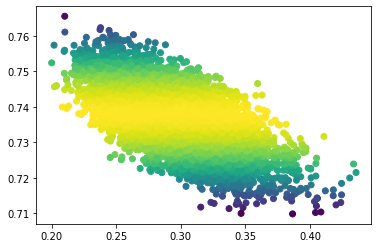

h_mean weighted with prior is 0.7367148886436272
Omega m weighted by prior(from h) is 0.29496642069748824


In [ ]:
'''IMPORTANCE SAMPLING'''


#FOR THE PRIOR
h_mean, h_std = 0.738, 0.024


def PRIOR(x):
    prior = (1/(h_std*(2*np.pi)**0.5))*np.exp(-(x-h_mean)**2/(2*(h_std)**2))
    return prior

#Weighting all the samples using prior distribution funtion
weights = np.empty(len(h_stationary))

for i in range(len(h_stationary)):
    weights[i]  = PRIOR(h_stationary[i])

# weightted average can eihther be found using numpy predefined function as 
h_weighted_avg = np.dot(h_stationary, weights)/np.sum(weights)
Omegam_weighted_avg = np.dot(w_m_stationary, weights)/np.sum(weights)

plt.scatter(w_m_stationary,h_stationary,c= weights,alpha=1)
plt.show()

print('h_mean weighted with prior is',h_weighted_avg)
print('Omega m weighted by prior(from h) is',Omegam_weighted_avg)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10


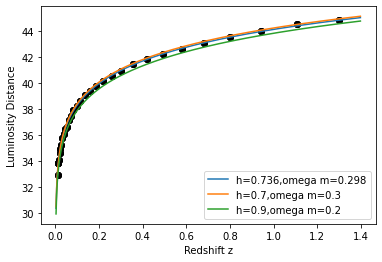

In [ ]:
#THIS IS TO PLOT THEORETICAL DISTANCE MODULUS 
#z=input("Enter the value of z for which you want Luminosity distance calculated:")
zforplots=1.4


hforplots=np.array([np.mean(h_stationary),0.7,0.9])
w_m_forplots=np.array([np.mean(w_m_stationary),0.3,0.2])
#ALL VALUES ARE IN S.I. UNITS

for s in range(len(hforplots)):

  #PARAMETER VALUES
  H0=hforplots[s] * 308.6 * 10 ** -20
  # H0 = 0.7 *  308.6 * 10 ** -20
  WR0=0
  WM0=w_m_forplots[s]
  WL0=1-WM0
  WK0=0
  C=299792458

  #FOR PRECISION LEVEL
  k=500

  Z=np.zeros(k)     #This will hold values for the redshift parameter
  T=np.zeros(k)     #This will hold values for Luminosity Distance
  Z[0]=0            #a(t_0)=1 needs z(t_0)=0
  Z[k-1]=zforplots         #Final z(t_e) value uptil which d_l will be calculated through the integral
  j=1
  while j<k:        #Using this loop I am determining t by integrating from Z[0] to Z[j]
    a=Z[0]
    Z[j]=Z[0]+(j)*(Z[k-1]-Z[0])/k     #I am evenly dividing Z from Z[0] to Z[k-1] to use Simpson's method
    b=Z[j]
    n=10000
    if j==0: n=1
    x=np.linspace(a,b,n+1)            #subsection of A from Z[0] to Z[j] in n divisions
    y=(WR0*(1+x)**4+WM0*(1+x)**3+WL0+WK0*(1+x)**2)**(-1/2)             #The Integrand for proper distance
    
    #Simpson's Integration
    h=x[1]-x[0]
    S=y[0]
    i=1
    while i<n:
      if i%2==0: S=S+2*y[i]
      if i%2==1: S=S+4*y[i]
      i=i+1
    S=S+y[n]
    S=h/3*S                                 #Final integral value using Simpson's rule
    T[j]=S*C*H0**-1*(1+Z[j])                     #Luminosity Distance as a funtion of z
    j=j+1
  dh=T*(3.24078*10**-23)
  Mu_th=5*np.log10(dh)+25  


  plt.scatter(z, Mo,c='k')
  plt.plot(Z,Mu_th,label=f'h={round(hforplots[s],3)},omega m={round(w_m_forplots[s],3)}')
  plt.xlabel("Redshift z")
  plt.ylabel("Luminosity Distance")
  plt.xscale("linear")
  plt.yscale("linear")
  plt.legend()

mean value of h is 0.7365466807702881
standard deviation of h is 0.00804956768428296
mean value of omega m is 0.2955339974383016
standard deviation of omega m is 0.03339347738195715


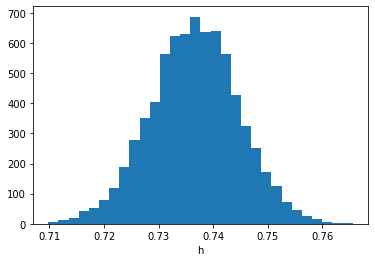

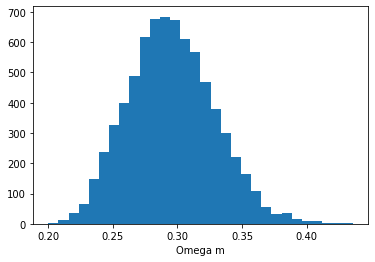

In [ ]:
print('mean value of h is',np.mean(h_stationary))
print('standard deviation of h is', np.std(h_stationary))
print('mean value of omega m is',np.mean(w_m_stationary))
print('standard deviation of omega m is', np.std(w_m_stationary))

plt.hist(h_stationary,bins=30)
plt.xlabel('h')
plt.show()

plt.hist(w_m_stationary,bins=30)
plt.xlabel('Omega m')
plt.show()



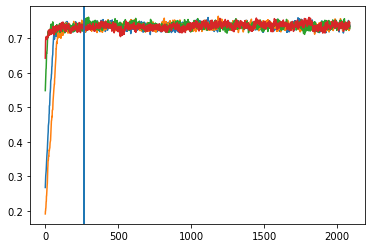

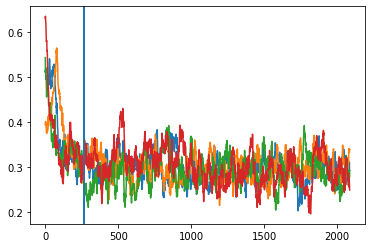

In [ ]:
#THIS IS TO PLOT THE TRACE PLOTS
min_len_chain = N
for i in range(no_of_chains):
    if len(x_h_master[i]) < min_len_chain:
        min_len_chain = len(x_h_master[i])
numbers=np.arange(min_len_chain)
for i in range(no_of_chains):
  plt.plot(numbers,np.array(x_h_master[i])[:min_len_chain])
  plt.axvline(cutoff)
plt.show()
for i in range(no_of_chains):
  plt.plot(numbers,np.array(y_w_master[i])[:min_len_chain])
  plt.axvline(cutoff)

In [ ]:
'''GELMAN RUBIN CONVERGENCE TEST'''


def G_R_convergence(no_of_chains,min_len_chain, x_h_master, y_w_master):
    #THIS IS THE VARIANCE BETWEEN CHAINS
    h_mean_i = np.array([np.mean(x_h_master[m]) for m in range(no_of_chains)])
    omegam_mean_i = np.array([np.mean(y_w_master[m]) for m in range(no_of_chains)])
    theta_hat_h = np.mean(h_mean_i)
    theta_hat_omegam = np.mean(omegam_mean_i)
    B_h = (min_len_chain/(no_of_chains-1))*np.sum((h_mean_i - theta_hat_h)**2)
    B_omegam = (min_len_chain/(no_of_chains-1))*np.sum((omegam_mean_i - theta_hat_omegam)**2)


    #THIS IS THE VARIANCE WITHIN A CHAIN
    h_variance_i = np.array([np.var(x_h_master[m]) for m in range(no_of_chains)])
    omegam_variance_i = np.array([np.var(y_w_master[m]) for m in range(no_of_chains)])
    W_h = np.mean(h_variance_i)
    W_omegam = np.mean(omegam_variance_i)

    
    var_minus_h = W_h
    var_plus_h = ((min_len_chain - 1)/min_len_chain)* W_h + ((no_of_chains+1)/(no_of_chains*min_len_chain))*B_h
    var_minus_omegam = W_omegam
    var_plus_omegam = ((min_len_chain - 1)/min_len_chain)* W_omegam + ((no_of_chains+1)/(no_of_chains*min_len_chain))*B_omegam

    R_hat_h = np.sqrt(var_plus_h / var_minus_h)
    R_hat_omegam = np.sqrt(var_plus_omegam / var_minus_omegam)

    return R_hat_h, R_hat_omegam

R_hat_h, R_hat_omegam = G_R_convergence(no_of_chains,min_len_chain, x_h_master, y_w_master)

print(f'''
R_hat for h        = {R_hat_h}
R_hat for Omega_m  = {R_hat_omegam}
''')


R_hat for h        = 1.011199604498831
R_hat for Omega_m  = 1.0089033298002184



In [ ]:
'''GENERALISABLE N DIMENSIONAL HAMILTONIAN MONTE CARLO'''


for_cov_mat = np.stack((h_stationary, w_m_stationary), axis = 0)

cov_of_guassian=np.cov(for_cov_mat)
inverse_of_guassian_cov = np.linalg.inv(cov_of_guassian)
mu_of_guassian=np.array([np.mean(h_stationary),np.mean(w_m_stationary)])


#THIS IS THE N DIMENSIONAL GUASSIAN UNDERLYING FOR THE U VALUE
def guassianee(xi , mu_of_guassian , cov_of_guassian , inverse_of_guassian_cov,no_of_parameters):
  diff=xi - mu_of_guassian
  return ((1/(2*np.pi)**(no_of_parameters/2))*np.linalg.det(cov_of_guassian)**(-0.5))*np.exp(-0.5*np.dot(diff, (np.dot(inverse_of_guassian_cov, diff))))



k_n=np.log(((1/(2*np.pi)**(no_of_parameters/2))*np.linalg.det(cov_of_guassian)**(-0.5)))

def U(x_i):
  diff=x_i - mu_of_guassian
  return -(-0.5*np.dot(diff, (np.dot(inverse_of_guassian_cov, diff)))) - k_n

#I AM NOT USING THE VALUES OF K OR H OR GUASSIANEE FOR THAT MATTER, THEY ARE THERE FOR CONVENIENT CHECKS
def K(p_i):
  return 0.5*p_i**2

def H(x_i,p_i):
  return U(x_i)+K(p_i)
###

def gradientU(x_i):
  dh=0.0001
  grad=np.zeros(no_of_parameters)
  for i in range(no_of_parameters):
    zeros=np.zeros(no_of_parameters)
    zeros[i]=dh
    xnew=x_i+zeros
    grad[i]=(U(xnew)-U(x_i))/dh
  return grad



#THE MAGIC PLACE
'''ENTER CAREFULLY EPSILON AND NO OF EPSILON STEPS FOR GOOD KICKS FOR THE PARTICLE'''
def leapfrog(x_i , p_i):
  epsilon=0.0005
  No_of_steps=100
  x=x_i
  for i in range(No_of_steps):  
    #Kick
    p_i = p_i - 0.5*epsilon*gradientU(x)
    #Drift
    x = x + epsilon*p_i
    #kick
    p_i = p_i - 0.5*epsilon*gradientU(x)
  return x



N_hmc = 500                #THIS IS FOR THE NO OF TRIALS WE WILL HAVE FOR THE PROPOSED DISTRIBUTION



#UNNECESSARY REDEFINING BUT ALSO HERE TO REMIND THAT I AM NOT TAKING DELTA H VALUES TO CHECK ACCEPTANCE CRITERIA BUT THE LIKELIHOOD ITSELF
def fu(h, w_m):
    if h < 1 and h > 0 and w_m > 0 and w_m < 1:
        DL = np.zeros(len(z))
        WM0 = w_m
        WL0 = 1 - WM0
        H0 = h * 308.5677 * 10 ** -20    #THIS IS IN S.I. UNITS
        WR0 = 0
        WK0 = 0
        n = 1000                      #THIS DETERMINES THE PRECISION
        for i in range(len(z)):
            x = np.linspace(0, z[i], n + 1)  # subsection of A from 0 to z in n divisions
            y = (WR0 * (1 + x) ** 4 + WM0 * (1 + x) ** 3 + WL0 + WK0 * (1 + x) ** 2) ** (
                        -1 / 2)  # The Integrand for proper distance

            # Simpson's Integration
            h = x[1] - x[0]
            S = y[0]
            for j in range(n):
                if j % 2 == 0: S = S + 2 * y[j]
                if j % 2 == 1: S = S + 4 * y[j]
            S = S + y[n]
            S = h / 3 * S  # Final integral value using Simpson's rule
            DL[i] = S * C * H0 ** -1 * (1 + z[i]) * (3.24078 * 10 ** -23)  # Luminosity Distance as a funtion of z
        Mu = 5 * np.log10(DL) + 25                                          #DISTANCE MODULUS
        DMu = Mo - Mu
        log_p = (-0.5 * np.dot(DMu, (np.dot(invCov, DMu))))               #LOG OF LIKELIHOOD
    else:
        log_p = -1*np.exp(100)        #SO THAT LIKELIHOOD ITSELF IS NEARLY ZERO
    return log_p






#THE INITIAL VALUE OR WHERE THE CHAINS ARE STARTING
x_h_hmc = np.array([np.random.uniform(0, 1)])
y_w_hmc = np.array([np.random.uniform(0, 1)])


likelihood_hmc = np.array([fu(x_h_hmc[0],y_w_hmc[0])])



#THE SAME PLACE AS FIRST PART'S MCMCM, THIS IS WHERE HMC IS HAPPENING
#IT IS THE SAME PROCEDURE AS BEFORE EXCEPT FOR PROPOSAL DISTRIBUTION

for iteration in range(N_hmc):
  a_prev=likelihood_hmc[-1]
  h = x_h_hmc[-1]
  w_m = y_w_hmc[-1]
  h_prev = copy.copy(h)
  w_prev = copy.copy(w_m)

  p=np.random.normal(0,1,no_of_parameters)

  #ENTER ALL THE PARAMETERS HERE AND THEN RETRIEVE THEM FROM new 
  xi=np.array([h_prev,w_prev])
  new = leapfrog(xi,p)
  h= new[0]
  w_m= new[1]
  a = fu(h,w_m)
  ac_pr = min(np.exp(a - a_prev), 1)
  if np.random.uniform(0, 1) < ac_pr:
    x_h_hmc = np.append(x_h_hmc, h)
    y_w_hmc = np.append(y_w_hmc, w_m)
    likelihood_hmc = np.append(likelihood_hmc,a)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in exp


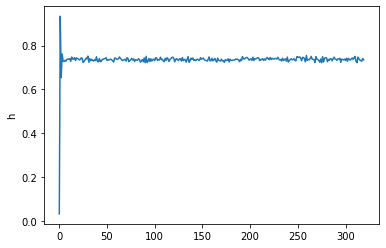

Text(0, 0.5, 'Omega m')

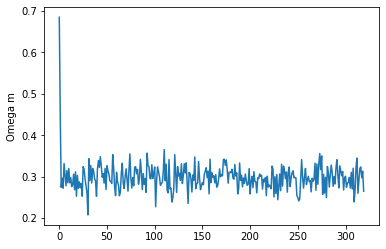

In [ ]:
'''THIS IS TO SHOWCASE THE ALMOST INSTANTANEOUS CONVERGENCE OF THE HMC I AM NOT DOING ANY STATISTICS WITH THE HMC HERE'''

numbers2=np.arange(len(x_h_hmc))
plt.plot(numbers2,x_h_hmc)
plt.ylabel('h')
plt.show()

plt.plot(numbers2,y_w_hmc)
plt.ylabel('Omega m')